# Word2Vec x MBKm

## Data

In [ ]:
# Import libraries 
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import gensim.downloader as api
from gensim.models import Word2Vec

from collections import Counter 
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")

from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Load data 
dataset = tfds.load("imdb_reviews", as_supervised = True)
unsup_data = dataset["unsupervised"]

# Unsupervised Data
unsup_sens = [str(s[0].numpy()) for s in unsup_data] 

# DataFrame Unsup
df = pd.DataFrame(unsup_sens, columns = ["text"])

In [3]:
# Function to clean and tokenize
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    
    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()                            # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)               # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)                    # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)                  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)         # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)                                            # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]                  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]                 # Remove digits
    tokens = [t for t in tokens if len(t) > 1]                          # Remove short tokens
    return tokens

In [4]:
# Apply function and remove duplicates
stop_words = set(stopwords.words("english"))

df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, stop_words))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

In [5]:
# Convert vocab by token
docs = df["text"].values
tokenized_docs = df["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [6]:
# Check vocab
vocab.most_common(10)

[('br', 114467),
 ('movie', 83804),
 ('film', 76140),
 ('one', 52238),
 ('like', 39851),
 ('good', 28801),
 ('even', 24223),
 ('time', 24029),
 ('would', 24025),
 ('really', 22801)]

### Load pretrained FastText

In [8]:
model = api.load("fasttext-wiki-news-subwords-300")
# model = Word2Vec(sentences=tokenized_docs, seed=42)

[==================================================] 100.0% 958.5/958.4MB downloaded


In [9]:
model.most_similar("movie")

[('film', 0.8769422769546509),
 ('movie-', 0.8271825313568115),
 ('movies', 0.7997194528579712),
 ('film--', 0.7811052799224854),
 ('movie.', 0.7665870189666748),
 ('film.', 0.7414735555648804),
 ('filmdom', 0.7352851629257202),
 ('mini-movie', 0.729194164276123),
 ('films', 0.7288245558738708),
 ('moviehouse', 0.728100061416626)]

### Generate vectors from document

In [12]:
# Function for creating a single vectors from word embeddings
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [11]:
# Apply function to previously pre-processed text
vectorized_docs = vectorize(tokenized_docs, model=model)

In [13]:
model.wv.most_similar("movie")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('film', 0.8769422769546509),
 ('movie-', 0.8271825313568115),
 ('movies', 0.7997194528579712),
 ('film--', 0.7811052799224854),
 ('movie.', 0.7665870189666748),
 ('film.', 0.7414735555648804),
 ('filmdom', 0.7352851629257202),
 ('mini-movie', 0.729194164276123),
 ('films', 0.7288245558738708),
 ('moviehouse', 0.728100061416626)]

## Generate and analyze clusters

In [14]:
# Mini-batch KMeans 
def mbkmeans_clusters(X, k, mb=512, print_silhouette_values=False):
    """ Generate clusters

    Args:
        X: Matrix of features.
        k: Number of clusters.
        # mb: Size of mini-batches. Defaults to 512.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_


`Inertia` measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

In [15]:
clusterer, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=2, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 2
Silhouette coefficient: 0.08
Inertia:901.5220866043011
Silhouette values:
    Cluster 1: Size:28540 | Avg:0.10 | Min:0.01 | Max: 0.25
    Cluster 0: Size:20966 | Avg:0.05 | Min:-0.03 | Max: 0.20


## Visualization

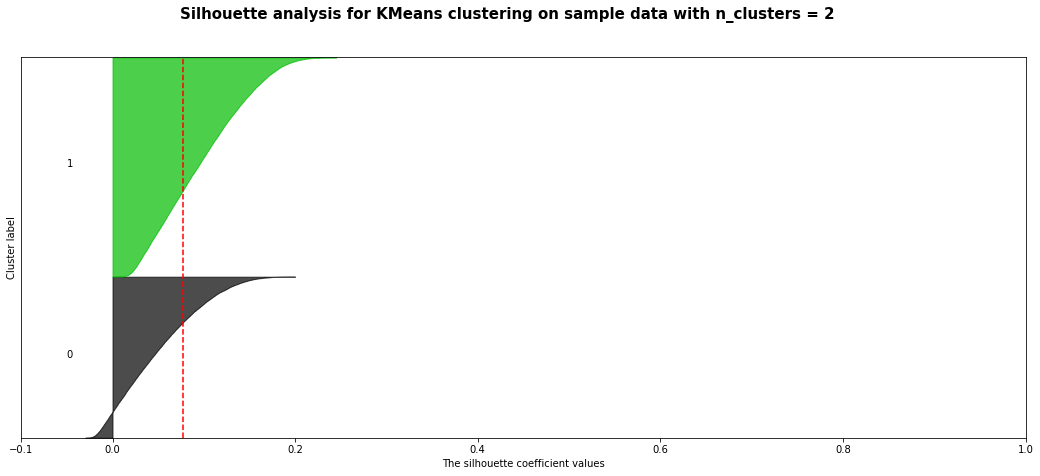

In [16]:
X = vectorized_docs
n_clusters = 2 

# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# Silhouette plot
# The silhouette coefficient can range from -1, 1
ax.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=15,
        fontweight="bold")

plt.show()

In [17]:
print("Top terms per cluster (based on centroids):")
for i in range(2):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clusterer.cluster_centers_[i]])
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: toook meak bady just strory seeen balnce wory excute visble 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Cluster 1: toook meak strory bady balnce thru-out visble fild cooool deline 


In [18]:
test_cluster = 0
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clusterer.cluster_centers_[test_cluster], axis=1))

for d in most_representative_docs[:2]:
    print(docs[d])
    print("-------------")

b'Although I\'m not a Star Wars fanatic (I certainly don\'t read the books or anything), I love the old Star Wars movies. In fact, when I was littler, The Empire Strikes Back was my favorite film. Now that I\'m older, I respect them for what they are: incredibly creative, exciting and touching films. I have yet to see Episode 1. My friend recommended Episode 2 to me, telling me that it was better than its predecessor, but warning me "don\'t see it if you expect anything more than a Star Wars movie." Maybe I just have a nostalgic love for the first trilogy, but I would never think that they were anywhere near as poor, in any way, as this new garbage. I can\'t think of a high budget movie that I\'ve seen that has such bad directing, bad acting, bad casting, bad special effects (or lack thereof), bad music, bad dialogue and bad plot, as ATTACK OF THE CLONES (bad title too). The reviewers on this site giving this movie positive reviews must all be brainwashed. Maybe they\'re all just excit

In [19]:
test_cluster = 1
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clusterer.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:2]:
    print(docs[d])
    print("-------------")

b"Originally planned as the first of a series, Young Sherlock Holmes was a bit of a misfire at the box office. It cost $18 million and only grossed about 20 per cent of its budget back. In the years since its release it has become a cult film for those who can appreciate it for the blockbuster it never was. I personally discovered it on a Christmas Eve showing on BBC in the late 80s. Even then, I thought it was great despite it being a darker Christmas film than we're used to.<br /><br />In a snowy and sinister December at the height of the Victorian Era, Watson, as a teenager, is sent to Brompton, a private school in a fogbound London, when his old one is shut down due to lack of funding. Upon arrival, he meets a violin-playing smart-Alec who deducts his character from his mere appearance. It's the beginning of a life-long friendship.<br /><br />Holmes' life on campus is rather cosy. He has a pretty girlfriend Elizabeth (Sophie Ward) and her uncle, Professor Waxflatter, is a crackpot 